## Feature Extraction from Booking.com Reviews

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import re
import spacy
from nltk import ngrams 
from collections import Counter
from collections import defaultdict
nlp = spacy.load('en_core_web_sm')

In [2]:
df = pd.read_excel('BookingDotCom_HotelReviews.xlsx')

In [38]:
df.head(5)

,Hotel_Name,Hotel_Address,Review_Count,Non_Review_Scoring_Count,Average_Hotel_Score,Review_Date,Reviewer_Nationality,Positive_Comments,Negative_Comments,Total_Reviewer_Reviews,Reviewer_Score,Tags,Positive_Features,Negative_Features
0,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Russia,only the park outside of the hotel was beauti...,i am so angry that i made this post available...,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",[],"[i am, am so, so angry, angry that, that i, i ..."
1,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Ireland,no real complaints the hotel was great great ...,no negative,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...","[real complaints, great great, great location,...",[no negative]
2,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,Australia,location was good and staff were ok it is cut...,rooms are nice but for elderly a bit difficul...,9,7.1,"[' Leisure trip ', ' Family with young childre...","[cute hotel, breakfast range]","[rooms are, are nice, nice but, but for, for e..."
3,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,United Kingdom,great location in nice surroundings the bar a...,my room was dirty and i was afraid to walk ba...,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...","[great location, nice surroundings, lovely out...","[my room, room was, was dirty, dirty and, and ..."
4,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-24,New Zealand,amazing location and building romantic setting,you when i booked with your company on line y...,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...","[amazing location, romantic setting]","[you when, when i, i booked, booked with, with..."


In [39]:
df.shape

(515738, 14)

## Q1. Top five hotel features
#### Approach 1 : Using NLTk (CountVectorizer)

In [40]:
# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply the cleaning function
df['Positive_Comments'] = df['Positive_Comments'].apply(lambda x: clean_text(str(x)))
df['Negative_Comments'] = df['Negative_Comments'].apply(lambda x: clean_text(str(x)))

In [41]:
stop_words = stopwords.words('english')

# Initialize CountVectorizer for positive and negative comments
vectorizer = CountVectorizer(stop_words=stop_words, max_features=20)  # Top 20 features

# Apply vectorizer
positive_comments = df['Positive_Comments'].dropna()
positive_matrix = vectorizer.fit_transform(positive_comments)

negative_comments = df['Negative_Comments'].dropna()
negative_matrix = vectorizer.fit_transform(negative_comments)

In [58]:
# Get the top words for positive comments
positive_words = vectorizer.get_feature_names_out()
positive_word_count = positive_matrix.sum(axis=0).A1
positive_word_freq = dict(zip(positive_words, positive_word_count))

# Sort and display top 5 features
top_positive_features = sorted(positive_word_freq.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Hotel Features in Positive Reviews:")
for feature, count in top_positive_features:
    print(f"{feature}: {count}")

# Get the top words for negative comments
negative_words = vectorizer.get_feature_names_out()
negative_word_count = negative_matrix.sum(axis=0).A1
negative_word_freq = dict(zip(negative_words, negative_word_count))

# Sort and display top 5 features
top_negative_features = sorted(negative_word_freq.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Hotel Features in Negative Reviews:")
for feature, count in top_negative_features:
    print(f"{feature}: {count}")

Top 5 Hotel Features in Positive Reviews:
staff: 194574
nothing: 192857
shower: 140756
night: 125330
like: 112321

Top 5 Hotel Features in Negative Reviews:
room: 176052
negative: 129447
hotel: 74709
breakfast: 58478
small: 49883


#### Approach 2 : Using (SpaCy POS Tagging)

In [44]:
def extract_nouns_and_adjectives(text):
    doc = nlp(text)
    features = []
    for token in doc:
        if token.pos_ in ['NOUN', 'ADJ']:  # Focus on nouns and adjectives
            features.append(token.lemma_)  # Lemmatize the word
    return features

df['Positive_Features'] = df['Positive_Comments'].apply(lambda x: extract_nouns_and_adjectives(str(x)))
df['Negative_Features'] = df['Negative_Comments'].apply(lambda x: extract_nouns_and_adjectives(str(x)))

In [45]:
# Define a list of non-informative features to exclude
non_informative_features = {'good', 'bad', 'hotel', 'bit','great','excellent', 'negative', 'positive', 'great', 'small', 'big', 'nice','night','average', 'poor'}

# Flatten the lists and count features, excluding non-informative ones
positive_features_list = [item for sublist in df['Positive_Features'].dropna() for item in sublist if item not in non_informative_features]
negative_features_list = [item for sublist in df['Negative_Features'].dropna() for item in sublist if item not in non_informative_features]

positive_feature_counts = Counter(positive_features_list).most_common(5)
negative_feature_counts = Counter(negative_features_list).most_common(5)
print("Top 5 Hotel Features in Positive Reviews:", positive_feature_counts)
print("Top 5 Hotel Features in Negative Reviews:", negative_feature_counts)


Top 5 Hotel Features in Positive Reviews: [('staff', 193251), ('location', 192130), ('room', 180478), ('friendly', 85362), ('breakfast', 85193)]
Top 5 Hotel Features in Negative Reviews: [('room', 208921), ('breakfast', 57798), ('staff', 39118), ('bed', 36977), ('bathroom', 27581)]


#### Approach 3 : Using (SpaCy Bigrams)

In [46]:
# Function to generate n-grams from text
def generate_ngrams(text, n):
    tokens = text.split()
    return [' '.join(gram) for gram in ngrams(tokens, n)]

# Function to filter meaningful bigrams using spaCy
def filter_meaningful_bigrams(text):
    doc = nlp(text)
    bigrams = generate_ngrams(text, 2)
    filtered_bigrams = []
    
    for bigram in bigrams:
        words = bigram.split()
        if all(token.pos_ in ['NOUN', 'ADJ'] for token in doc if token.text in words):
            filtered_bigrams.append(bigram)
    return filtered_bigrams

df['Positive_Features'] = df['Positive_Comments'].apply(lambda x: filter_meaningful_bigrams(str(x)))
df['Negative_Features'] = df['Negative_Comments'].apply(lambda x: filter_meaningful_bigrams(str(x)))

# Flatten the lists and count features
positive_features_list_1 = [item for sublist in df['Positive_Features'].dropna() for item in sublist]
negative_features_list_1 = [item for sublist in df['Negative_Features'].dropna() for item in sublist]

positive_feature_counts_1 = Counter(positive_features_list_1).most_common(5)
negative_feature_counts_1 = Counter(negative_features_list_1).most_common(5)
print("Top 5 Hotel Features in Positive Reviews (All reviews):", positive_feature_counts_1)
print("Top 5 Hotel Features in Negative Reviews (All reviews):", negative_feature_counts_1)

Top 5 Hotel Features in Positive Reviews (All reviews): [('great location', 29737), ('friendly staff', 24505), ('good location', 19115), ('helpful staff', 16724), ('excellent location', 11544)]
Top 5 Hotel Features in Negative Reviews (All reviews): [('room service', 6125), ('air conditioning', 5155), ('small room', 5049), ('star hotel', 4035), ('double bed', 2775)]


In [72]:
# Count the top features
positive_feature_counts_1 = Counter(positive_features_list_1).most_common(20)
negative_feature_counts_1 = Counter(negative_features_list_1).most_common(20)

# Display the results
print("Top 20 Hotel Features in Positive Reviews (All reviews):", positive_feature_counts_1)
print("Top 20 Hotel Features in Negative Reviews (All reviews):", negative_feature_counts_1)

Top 20 Hotel Features in Positive Reviews (All reviews): [('great location', 29737), ('friendly staff', 24505), ('good location', 19115), ('helpful staff', 16724), ('excellent location', 11544), ('good breakfast', 8755), ('comfortable bed', 8680), ('comfy bed', 6303), ('perfect location', 5834), ('comfortable room', 5002), ('clean room', 4662), ('great staff', 4650), ('great breakfast', 4610), ('train station', 4552), ('good value', 4481), ('tube station', 4331), ('reception staff', 4242), ('excellent breakfast', 4056), ('friendly helpful', 3853), ('location staff', 3815)]
Top 20 Hotel Features in Negative Reviews (All reviews): [('room service', 6125), ('air conditioning', 5155), ('small room', 5049), ('star hotel', 4035), ('double bed', 2775), ('front desk', 2770), ('little bit', 2756), ('mini bar', 2686), ('bit small', 2317), ('double room', 2173), ('reception staff', 2065), ('hot water', 2057), ('small rooms', 1907), ('wi fi', 1853), ('breakfast room', 1827), ('swimming pool', 1825

### Comparing all results

In [65]:
positive_features_1 = [('staff', 194574), ('nothing', 192857), ('shower', 140756), ('night', 125330), ('like', 112321)]
negative_features_1 = [('room', 176052), ('negative', 129447), ('hotel', 74709), ('breakfast', 58478), ('small', 49883)]

positive_features_2 = [('staff', 193251), ('location', 192130), ('room', 180478), ('friendly', 85362), ('breakfast', 85193)]
negative_features_2 = [('room', 208921), ('breakfast', 57798), ('staff', 39118), ('bed', 36977), ('bathroom', 27581)]

positive_features_3 = [('great location', 29737), ('friendly staff', 24505), ('good location', 19115), ('helpful staff', 16724), ('excellent location', 11544)]
negative_features_3 = [('room service', 6125), ('air conditioning', 5155), ('small room', 5049), ('star hotel', 4035), ('double bed', 2775)]

# Create DataFrames for the positive and negative features
positive_df = pd.DataFrame({
    'Approach 1 (CountVectorizer)': [f"{feature} ({count})" for feature, count in positive_features_1],
    'Approach 2 (SpaCy POS Tagging)': [f"{feature} ({count})" for feature, count in positive_features_2],
    'Approach 3 (SpaCy Bigrams)': [f"{feature} ({count})" for feature, count in positive_features_3]
})

negative_df = pd.DataFrame({
    'Approach 1 (CountVectorizer)': [f"{feature} ({count})" for feature, count in negative_features_1],
    'Approach 2 (SpaCy POS Tagging)': [f"{feature} ({count})" for feature, count in negative_features_2],
    'Approach 3 (SpaCy Bigrams)': [f"{feature} ({count})" for feature, count in negative_features_3]
})

In [66]:
# Display the DataFrames for positive and negative features
print("Top 5 Hotel Features in Positive Reviews:")
positive_df

Top 5 Hotel Features in Positive Reviews:


,Approach 1 (CountVectorizer),Approach 2 (SpaCy POS Tagging),Approach 3 (SpaCy Bigrams)
0,staff (194574),staff (193251),great location (29737)
1,nothing (192857),location (192130),friendly staff (24505)
2,shower (140756),room (180478),good location (19115)
3,night (125330),friendly (85362),helpful staff (16724)
4,like (112321),breakfast (85193),excellent location (11544)


In [67]:
print("\nTop 5 Hotel Features in Negative Reviews:")
negative_df


Top 5 Hotel Features in Negative Reviews:


,Approach 1 (CountVectorizer),Approach 2 (SpaCy POS Tagging),Approach 3 (SpaCy Bigrams)
0,room (176052),room (208921),room service (6125)
1,negative (129447),breakfast (57798),air conditioning (5155)
2,hotel (74709),staff (39118),small room (5049)
3,breakfast (58478),bed (36977),star hotel (4035)
4,small (49883),bathroom (27581),double bed (2775)


## Q2. Top five features in Different Categories
#### solo traveler vs traveling with a group vs on a business trip vs a leisure trip vs traveling as a couple vs a family with young children. 

In [89]:
from collections import Counter

# Define non-informative features to exclude
non_informative_features = {'good', 'bad', 'hotel', 'bit','great','excellent', 'negative', 'positive', 'great', 'small', 'big', 'nice','night','average','rooms', 'poor'}

# Travel categories
travel_categories = {
    'solo': [' Solo traveler '],
    'group': [' Group '],
    'business': [' Business trip '],
    'leisure': [' Leisure trip '],
    'couple': [' Couple '],
    'family': [' Family with young children ']
}

# Function to split tags and filter based on category
def get_top_unique_features_by_category(df, category_tag, travel_categories, num_features=5):
    # Filter the dataframe for the specific travel category based on matching tags
    category_reviews = df[df['Tags'].apply(lambda tags: any(tag in tags for tag in travel_categories[category_tag]) if isinstance(tags, str) else False)]
    
    if category_reviews.empty:
        return [], []
    
    # Get Positive and Negative Features, excluding non-informative features
    positive_features_list = [feature for sublist in category_reviews['Positive_Features'] for feature in sublist if feature not in non_informative_features]
    negative_features_list = [feature for sublist in category_reviews['Negative_Features'] for feature in sublist if feature not in non_informative_features]
    
    # Extract the second word in the bigram
    positive_filtered = [feature.split()[-1] for feature in positive_features_list if len(feature.split()) > 1]
    negative_filtered = [feature.split()[-1] for feature in negative_features_list if len(feature.split()) > 1]
    
    # Count the top features and ensure they are unique
    positive_top = [feature for feature, _ in Counter(positive_filtered).most_common() if feature not in non_informative_features][:num_features]
    negative_top = [feature for feature, _ in Counter(negative_filtered).most_common() if feature not in non_informative_features][:num_features]
    
    return positive_top, negative_top

# Loop through each travel category and extract the top 5 unique features
for category in travel_categories:
    positive_top, negative_top = get_top_unique_features_by_category(df, category, travel_categories)
    
    # Print the results
    print(f"Top 5 Positive Features for {category.capitalize()} Travelers:", positive_top)
    print(f"Top 5 Negative Features for {category.capitalize()} Travelers:", negative_top)
    print('-' * 80)


Top 5 Positive Features for Solo Travelers: ['staff', 'location', 'room', 'breakfast', 'bed']
Top 5 Negative Features for Solo Travelers: ['room', 'service', 'staff', 'breakfast', 'floor']
--------------------------------------------------------------------------------
Top 5 Positive Features for Group Travelers: ['staff', 'location', 'room', 'breakfast', 'station']
Top 5 Negative Features for Group Travelers: ['room', 'staff', 'service', 'breakfast', 'bed']
--------------------------------------------------------------------------------
Top 5 Positive Features for Business Travelers: ['staff', 'location', 'room', 'breakfast', 'bed']
Top 5 Negative Features for Business Travelers: ['room', 'breakfast', 'staff', 'service', 'floor']
--------------------------------------------------------------------------------
Top 5 Positive Features for Leisure Travelers: ['staff', 'location', 'room', 'breakfast', 'bed']
Top 5 Negative Features for Leisure Travelers: ['room', 'staff', 'breakfast', 'se

## Q3. Country wise trend for Hotels
#### Top five features customers like the most and top five features they complain about most about hotels 

In [98]:
# Define a list of non-informative features to exclude, including common words like "room" and "hotel"
non_informative_features = {'good', 'bad', 'hotel', 'bit', 'great', 'excellent', 'negative', 'positive', 
                            'small', 'big', 'nice', 'average', 'poor', 'room', 'rooms','staff','service','friendly', 'time','clean','day'}

# Function to keep only the second word in a bigram or the single word in a unigram
def clean_feature(feature):
    words = feature.split()
    return words[-1] if len(words) > 1 else feature

# Function to filter and exclude non-informative words
def is_informative(feature):
    clean = clean_feature(feature).lower()  # Extract the relevant word and make it lowercase
    return clean not in non_informative_features

# Function to filter data by country and extract top unique features
def get_top_unique_features_by_country(df, country, num_features=5):
    # Filter the dataframe for the specified country
    country_reviews = df[df['Hotel_Address'].str.contains(country)]
    
    if country_reviews.empty:
        return [], []
    
    # Get Positive and Negative Features, excluding non-informative features
    positive_features_list = [clean_feature(feature) for sublist in country_reviews['Positive_Features'] 
                              for feature in sublist if is_informative(feature)]
    negative_features_list = [clean_feature(feature) for sublist in country_reviews['Negative_Features'] 
                              for feature in sublist if is_informative(feature)]
    
    # Count the top unique features
    positive_top = [feature for feature, _ in Counter(positive_features_list).most_common()][:num_features]
    negative_top = [feature for feature, _ in Counter(negative_features_list).most_common()][:num_features]
    
    return positive_top, negative_top

# List of countries
countries = ['United Kingdom', 'France', 'Italy', 'Spain']

# Loop through each country and extract the top 5 unique features
for country in countries:
    positive_top, negative_top = get_top_unique_features_by_country(df, country)
    
    # Print the results
    print(f"Top 5 Positive Features for Hotels in {country}: {positive_top}")
    print(f"Top 5 Negative Features for Hotels in {country}: {negative_top}")
    print('-' * 80)


Top 5 Positive Features for Hotels in United Kingdom: ['location', 'breakfast', 'bed', 'station', 'comfortable']
Top 5 Negative Features for Hotels in United Kingdom: ['breakfast', 'bed', 'floor', 'bar', 'area']
--------------------------------------------------------------------------------
Top 5 Positive Features for Hotels in France: ['location', 'breakfast', 'bed', 'tower', 'station']
Top 5 Negative Features for Hotels in France: ['breakfast', 'bed', 'floor', 'area', 'water']
--------------------------------------------------------------------------------
Top 5 Positive Features for Hotels in Italy: ['location', 'breakfast', 'station', 'bed', 'comfortable']
Top 5 Negative Features for Hotels in Italy: ['breakfast', 'area', 'bed', 'floor', 'station']
--------------------------------------------------------------------------------
Top 5 Positive Features for Hotels in Spain: ['location', 'breakfast', 'bed', 'pool', 'area']
Top 5 Negative Features for Hotels in Spain: ['pool', 'breakf

## Q4. Dashboard
#### (1) "Top Five Hotels Overall" 
#### (2) "Bottom Five Hotels Overall"
#### (3) "Five Most Improved Hotels from 2015 to 2017"

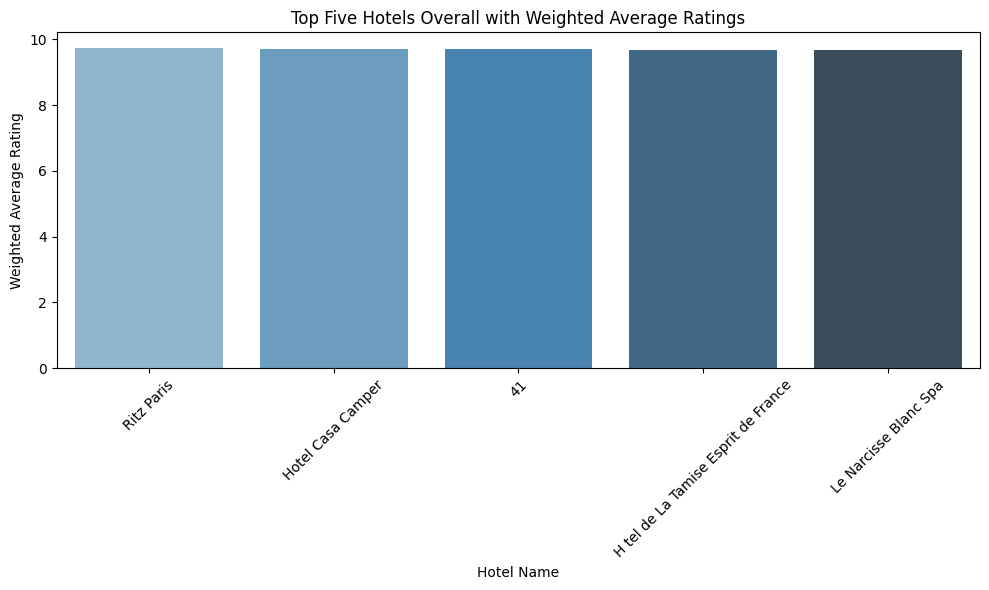

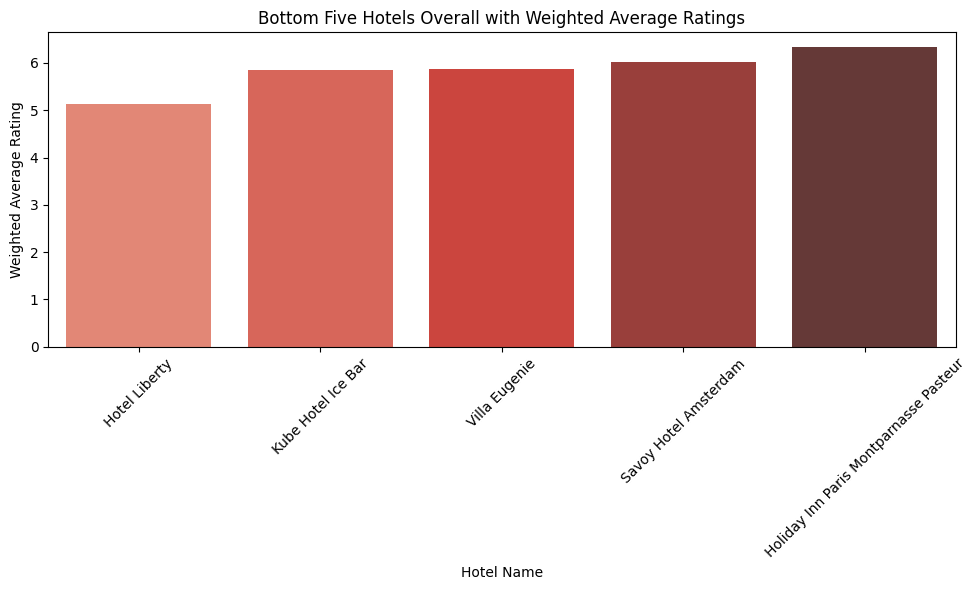

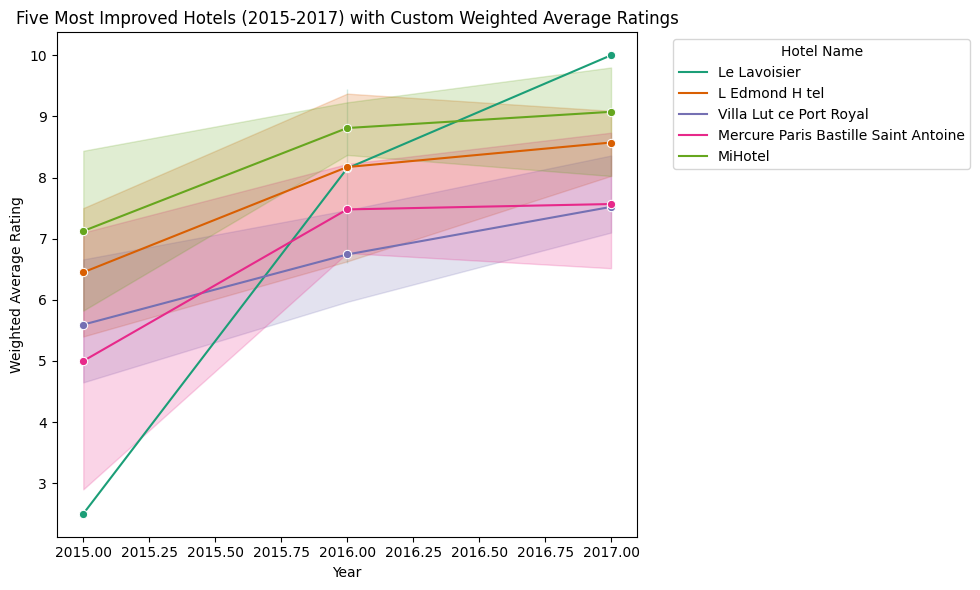

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df['Review_Date'] = pd.to_datetime(df['Review_Date'])

# Extract the year from the 'Review_Date'
df['Review_Year'] = df['Review_Date'].dt.year

# Step 1: Calculate total weighted score and total number of reviews per hotel
weighted_ratings = df.groupby('Hotel_Name').apply(
    lambda x: (x['Reviewer_Score'] * x['Review_Count']).sum() / x['Review_Count'].sum()
)

# Step 2: Sort to find top 5 and bottom 5 hotels
top_five_hotels = weighted_ratings.nlargest(5)
bottom_five_hotels = weighted_ratings.nsmallest(5)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_five_hotels.index, y=top_five_hotels.values, palette="Blues_d")
plt.title('Top Five Hotels Overall with Weighted Average Ratings')
plt.xlabel('Hotel Name')
plt.ylabel('Weighted Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=bottom_five_hotels.index, y=bottom_five_hotels.values, palette="Reds_d")
plt.title('Bottom Five Hotels Overall with Weighted Average Ratings')
plt.xlabel('Hotel Name')
plt.ylabel('Weighted Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Plot 3: Five Most Improved Hotels with Weighted Average Rating
# Calculate the weighted average rating for each hotel for 2015 and 2017

ratings_2015 = df[df['Review_Year'] == 2015].groupby('Hotel_Name').apply(
    lambda x: (x['Reviewer_Score'] * x['Review_Count']).sum() / x['Review_Count'].sum()
)
ratings_2017 = df[df['Review_Year'] == 2017].groupby('Hotel_Name').apply(
    lambda x: (x['Reviewer_Score'] * x['Review_Count']).sum() / x['Review_Count'].sum()
)

# Calculate the difference between 2015 and 2017 ratings
ratings_change = (ratings_2017 - ratings_2015).dropna()

# Find the top 5 hotels with the highest improvement
top_improved_hotels = ratings_change.nlargest(5)

# Prepare a DataFrame for plotting most improved hotels
most_improved_df = df[df['Hotel_Name'].isin(top_improved_hotels.index)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=most_improved_df, x='Review_Year', y='Reviewer_Score', hue='Hotel_Name', marker="o", palette="Dark2")
plt.title('Five Most Improved Hotels (2015-2017) with Custom Weighted Average Ratings')
plt.xlabel('Year')
plt.ylabel('Weighted Average Rating')
plt.legend(title='Hotel Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Summary Report for Hotel Review Analysis

This project involved analyzing over 515,000 guest reviews and ratings from Booking.com, focusing on identifying key hotel features in both positive and negative reviews, as well as understanding traveler preferences across different categories. The dataset covers almost 1,500 hotels across Europe, and we used various natural language processing techniques and visualizations to extract meaningful insights.

#### Data Preprocessing
The data was initially cleaned by removing unicode characters and punctuation and converting all text to lowercase. No additional preprocessing was applied to maintain the integrity of the raw reviews for natural language analysis. The fields provided in the dataset include `Hotel_Name`, `Hotel_Address`, `Review_Count`, `Average_Hotel_Score`, `Review_Date`, `Reviewer_Score`, `Tags`, `Positive_Comments`, `Negative_Comments`, and several others.

---

### Key Questions Addressed

#### 1. Top Five Hotel Features in Positive and Negative Reviews
We applied three different approaches (CountVectorizer, SpaCy POS tagging, and SpaCy Bigrams) to identify the most mentioned features in both positive and negative reviews.

##### Positive Features:
- **Approach 1 (CountVectorizer):** Staff, Nothing, Shower, Night, Like
- **Approach 2 (SpaCy POS Tagging):** Staff, Location, Room, Friendly, Breakfast
- **Approach 3 (SpaCy Bigrams):** Great Location, Friendly Staff, Good Location, Helpful Staff, Excellent Location

##### Negative Features:
- **Approach 1 (CountVectorizer):** Room, Negative, Hotel, Breakfast, Small
- **Approach 2 (SpaCy POS Tagging):** Room, Breakfast, Staff, Bed, Bathroom
- **Approach 3 (SpaCy Bigrams):** Room Service, Air Conditioning, Small Room, Star Hotel, Double Bed

These features provided insights into the most discussed aspects of hotels, highlighting common points of satisfaction (e.g., staff, location) and dissatisfaction (e.g., room size, service).

---

#### 2. Traveler Preferences Based on Tags
We examined traveler preferences across different categories, including solo travelers, group travelers, business trips, leisure trips, couples, and families with young children.

##### Positive Features by Category:
- **Solo Travelers:** Staff, Location, Room, Breakfast, Bed
- **Group Travelers:** Staff, Location, Room, Breakfast, Station
- **Business Travelers:** Staff, Location, Room, Breakfast, Bed
- **Leisure Travelers:** Staff, Location, Room, Breakfast, Bed
- **Couple Travelers:** Staff, Location, Room, Breakfast, Bed
- **Family Travelers:** Staff, Location, Room, Breakfast, Station

##### Negative Features by Category:
- **Solo Travelers:** Room, Service, Staff, Breakfast, Floor
- **Group Travelers:** Room, Staff, Service, Breakfast, Bed
- **Business Travelers:** Room, Breakfast, Staff, Service, Floor
- **Leisure Travelers:** Room, Staff, Breakfast, Service, Bed
- **Couple Travelers:** Room, Breakfast, Staff, Service, Bed
- **Family Travelers:** Room, Staff, Bed, Breakfast, Service

This analysis helped in understanding how different types of travelers prioritize hotel features, which can be valuable for hotel managers to tailor their services.

---

#### 3. Country-Specific Hotel Features
We explored the top features that guests mention the most in reviews from the United Kingdom, France, Italy, and Spain.

##### Positive Features by Country:
- **United Kingdom:** Location, Breakfast, Bed, Station, Comfortable
- **France:** Location, Breakfast, Bed, Tower, Station
- **Italy:** Location, Breakfast, Station, Bed, Comfortable
- **Spain:** Location, Breakfast, Bed, Pool, Area

##### Negative Features by Country:
- **United Kingdom:** Breakfast, Bed, Floor, Bar, Area
- **France:** Breakfast, Bed, Floor, Area, Water
- **Italy:** Breakfast, Area, Bed, Floor, Station
- **Spain:** Pool, Breakfast, Area, Bed, Bar

This analysis highlighted how guest preferences and complaints vary by country, with location and breakfast being the most commonly mentioned positive features, while room and bed quality often appeared as negative aspects.

---

#### 4. Dashboard Visualizations
We created three main plots to visualize hotel performance:

1. **Top Five Hotels Overall**: 
   - Hotels with the highest average weighted ratings based on customer reviews. Examples include *Ritz Paris* and *Hotel Casa Camper*.

2. **Bottom Five Hotels Overall**: 
   - Hotels with the lowest average weighted ratings. Examples include *Hotel Liberty* and *Kube Hotel Ice Bar*.

3. **Five Most Improved Hotels (2015-2017)**: 
   - This plot highlighted the hotels that showed the most improvement in customer ratings over time. Examples include *Le Lavoisier* and *Villa Lutèce Port Royal*.

---

### Conclusion
This project provided valuable insights into customer satisfaction across different hotels in Europe. By analyzing both positive and negative reviews, as well as understanding traveler preferences and country-specific trends, we gained a comprehensive view of what drives customer experiences. The dashboard helped visualize hotel performance over time, identifying top-rated hotels and those with room for improvement.

This analysis can assist hotel managers in enhancing their services and addressing common issues raised by guests, ultimately improving the overall guest experience.